# Tracking Single Players on Fangraphs

### MSP 8.5.2017

Can the fangraphs page be readable smoothly?

In [ ]:
from IPython.display import HTML
HTML('''<script>code_show=true; function code_toggle() { if (code_show){ $('div.input').hide();} else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
# boilerplate imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
# imports for scraping

from bs4 import BeautifulSoup
import requests


# basic birth year reader. tables[1] has good stuff in it!
def get_birth_year(tables):

    birthdate_start = (tables[1].text).find("Birthdate:")

    birthdate_end =  (tables[1].text).find('(',birthdate_start)

    #print (tables[1].text)[birthdate_start:birthdate_end]
    birth_year = (tables[1].text)[birthdate_start:birthdate_end].split('/')[2]
    #print birth_year
    
    return birth_year





In [3]:
# the listing of the teams of interest (all!)

teams = ['angels','astros','athletics','bluejays','braves',\
        'brewers','cardinals','cubs','diamondbacks','dodgers',\
        'giants','indians','mariners','marlins','mets','nationals',\
        'orioles','padres','phillies','pirates','rangers',\
        'rays','redsox','rockies','royals','tigers','twins',\
        'whitesox','yankees']



#### Compile Hitters

This cell only needs to be run in the event that player ID numbers change, or new players are added.

In [4]:

HDict = {}

f = open('data/batterdict.dat')

for line in f:
    #print line
    try:
        HDict[(line.split('|')[0]).strip()] = line.split('|')[1]
    except:
        pass
    
    
print('Found {} hitters by scraping teams.'.format(len(HDict.keys())))

Found 821 hitters by scraping teams.


#### Compile Pitchers

This cell only needs to be run in the event that player ID numbers change, or new players are added.

In [5]:

PDict = {}

f = open('data/pitcherdict.dat')

for line in f:
    #print line
    try:
        PDict[(line.split('|')[0]).strip()] = line.split('|')[1]
    except:
        pass
    

print('Found {} pitchers by scraping teams.'.format(len(PDict.keys())))

Found 648 pitchers by scraping teams.


### First Application: Aging Curves

For pitchers, how does K/9 evolve with age?

In [6]:
#
# for an individual player
#'

itable = [u'Season', u'Team', u'W', u'L', u'SV', u'G', u'GS', \
          u'IP', u'K/9', u'BB/9', u'HR/9', u'BABIP', u'LOB%', \
          u'GB%', u'HR/FB', u'ERA', u'FIP', u'xFIP', u'WAR']
#             0         1        2    3     4      5     6  \
#            7      8       9       10       11          12     \
#            13     14       15       16       17      18


# these are categories to eliminate
projections = ['Depth Charts','Fans',\
               'Fans (6)','Fans (7)','Fans (11)','Fans (12)','Fans (14)','Fans (15)',\
               'Steamer',\
               'ZiPS', 'ZiPS (R)','Steamer (R)','Depth Charts (R)','Average','Postseason']

minors = ['(AA)','(A)','(AAA)','(R)','(A+)','(A-)']

agg = ['Total','Postseason']


# now make a dictionary
PVals = {}

pnum = 0

for player in PDict.keys():
    PVals[player] = {}
    #print player

    get_url = 'http://www.fangraphs.com/statss.aspx?playerid='+str(PDict[player].strip())

    r  = requests.get(get_url)

    data = r.text

    soup = BeautifulSoup(data)

    tables = soup.findAll('table')

    birth_year = float(get_birth_year(tables))

    PVals[player]['age'] = []
    PVals[player]['k9'] = []
    PVals[player]['bb9'] = []
    PVals[player]['hr9'] = []



    
    for indx,table in enumerate(tables):

        #print indx,[th.get_text() for th in table.find("tr").find_all("th")]
   
        if [th.get_text() for th in table.find("tr").find_all("th")] == itable:
        
            #print get_url
            print pnum,player
            
            pnum += 1
        
            #print [th.get_text() for th in table.find("tr").find_all("th")]
        
            #print table.find_all("tr", class_="grid_multi")
        
            for row in table.find_all("tr")[1:]:
                
                if (row in table.find_all("tr", class_="grid_postseason")) |\
                    (row in table.find_all("tr", class_="grid_multi")):
                        #print 'Multi and/or Postseason:',sav[0]
                        continue


                sav = [td.get_text() for td in row.find_all("td")]
            
                if (np.sum([(x.strip() in sav[1]) for x in projections])==0) & \
                (np.sum([(x in sav[1]) for x in minors])==0) & \
                (np.sum([(x in sav[0]) for x in agg])==0): 
                    try:
                        float(sav[-1])
                        float(sav[0])
                        
                        #print sav[0],sav[1]
                                            
                        # current problem is that postseason is mixed in
                    
                        if (float(sav[8]) > 0.) & (float(sav[7])>50.):
                            PVals[player]['age'].append(float(sav[0])-birth_year)
                            PVals[player]['k9'].append(float(sav[8]))
                            PVals[player]['bb9'].append(float(sav[9]))
                            PVals[player]['hr9'].append(float(sav[10]))
                            
                        #if (float(sav[7])<50.):
                        #    print 'rejected for too few innings:',sav[0],float(sav[7])
                        
                    except:
                        # this is janky way to skip postseason. please fix this
                        #print 'Skipped for postseason',sav[0],sav[1]
                        pass


0 Chaz Roe
1 Chase Anderson
2 Parker Bridwell
3 Roberto Osuna
4 Dylan Covey
5 Scott Oberg
6 Jeremy Guthrie
7 Matt Belisle
8 Tony Watson
9 Rafael Montero
10 Emilio Pagan
11 Michael Wacha
12 Zack Greinke
13 Robbie Ray
14 Dustin McGowan
15 Jharel Cotton
16 Ian Krol
17 Joe Blanton
18 Justin Wilson
19 Drew Pomeranz
20 Jeff Hoffman
21 Paul Sewald
22 Jandel Gustave
23 Daniel Coulombe
24 Nate Jones
25 Jake Thompson
26 Aaron Blair
27 Jhan Marinez
28 Yusmeiro Petit
29 Steve Cishek
30 Alex Wood
31 Jason Wheeler
32 Tanner Scheppers
33 Matt Dermody
34 Leonel Campos
35 Drew Steckenrider
36 Alex Wimmers
37 Mat Latos
38 J.P. Howell
39 Tony Barnette
40 Daniel Stumpf
41 Jimmy Nelson
42 Fernando Abad
43 Derek Holland
44 Danny Duffy
45 Robert Gsellman
46 Justin Nicolino
47 Francis Martes
48 Evan Marshall
49 Grant Dayton
50 Felix Pena
51 Lance Lynn
52 Jerad Eickhoff
53 Jumbo Diaz
54 Edgar Santana
55 Jake Barrett
56 Rex Brothers
57 Antonio Bastardo
58 Nik Turley
59 Domingo German
60 Chris Hatcher
61 Blake P

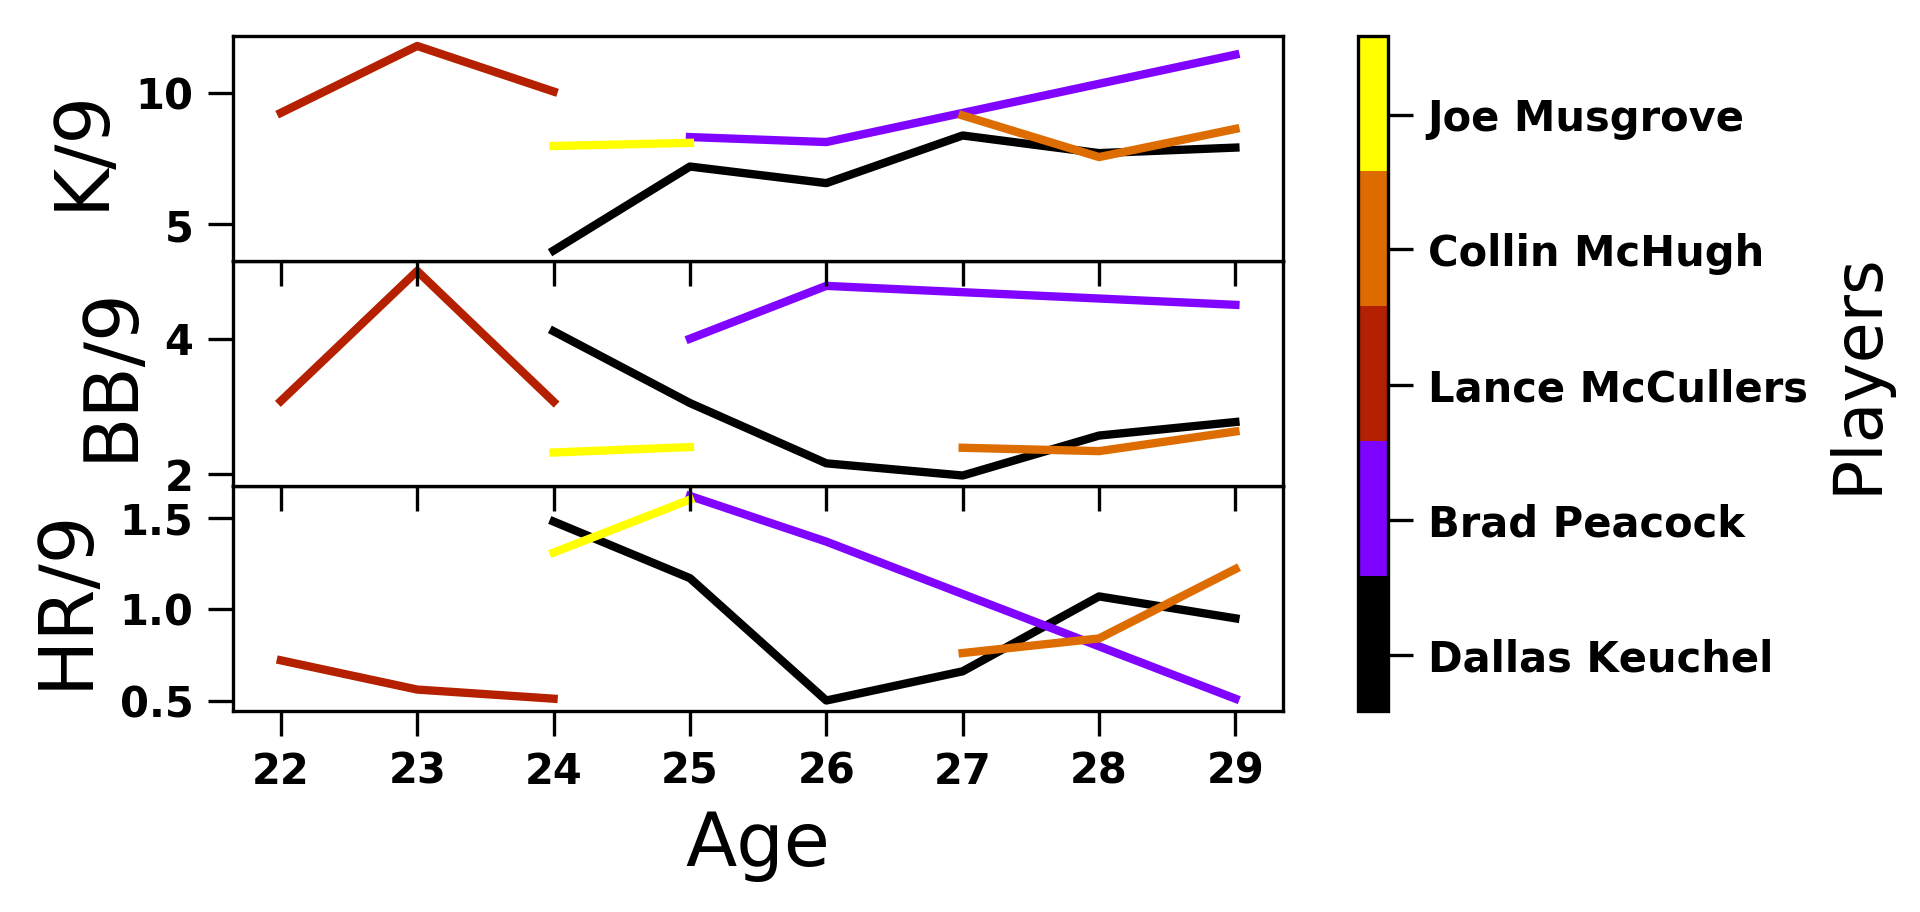

In [7]:
fig = plt.figure(figsize=(4,3))

#print PVals

plist = ['Brad Peacock']

#plist = ['Clay Buchholz','John Lackey','Rick Porcello','Jon Lester']

#plist = ['Noah Syndergaard','Jacob deGrom', 'Matt Harvey','Steven Matz']


plist = ['Dallas Keuchel','Brad Peacock', 'Lance McCullers','Collin McHugh','Joe Musgrove']



#plist = ['Kenley Jansen','Craig Kimbrel','Aroldis Chapman']

fig = plt.figure(figsize=(5,3))

ax3 = fig.add_axes([0.15,0.15,0.7,0.25])
ax2 = fig.add_axes([0.15,0.40,0.7,0.25])
ax1 = fig.add_axes([0.15,0.65,0.7,0.25])


ax4 = fig.add_axes([0.9,0.15,0.02,0.75])



clrs = cm.gnuplot


for indx,player in enumerate(plist):
    ax1.plot(PVals[player]['age'],PVals[player]['k9'],color=cm.gnuplot(indx/float(len(plist)-1.),1.))
    ax2.plot(PVals[player]['age'],PVals[player]['bb9'],color=cm.gnuplot(indx/float(len(plist)-1.),1.))
    ax3.plot(PVals[player]['age'],PVals[player]['hr9'],color=cm.gnuplot(indx/float(len(plist)-1.),1.))



    
ax3.set_xlabel('Age',size=18)
ax1.set_ylabel('K/9',size=18)
ax2.set_ylabel('BB/9',size=18)
ax3.set_ylabel('HR/9',size=18)

ax2.set_xticklabels(())
ax1.set_xticklabels(())



import matplotlib as mpl

norm = mpl.colors.BoundaryNorm(boundaries=np.linspace(0,1.,len(plist)+1.), ncolors=256)
cb1 = mpl.colorbar.ColorbarBase(ax4, cmap=cm.gnuplot,norm=norm)
cb1.set_label('Players',size=16)
cb1.set_ticks(np.linspace(0.,1.,len(plist)+1.) + 0.5/(len(plist)+1.))
cb1.set_ticklabels(plist)



#ax1.set_ylabel('Run Differential',size=18)

In [11]:
for player in PVals.keys():
    print(PVals[player]['age'])



[]
[27.0, 28.0, 29.0, 30.0]
[26.0]
[20.0, 21.0]
[]
[25.0]
[26.0, 27.0, 28.0, 29.0, 30.0]
[28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0]
[25.0, 27.0, 30.0, 31.0, 32.0, 33.0, 34.0]
[27.0, 28.0, 29.0, 30.0, 31.0, 32.0]
[27.0]
[]
[22.0, 23.0, 24.0, 25.0, 26.0]
[21.0, 22.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0]
[24.0, 25.0, 26.0]
[25.0, 26.0, 32.0, 34.0, 35.0]
[25.0]
[25.0]
[25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 32.0, 33.0, 35.0, 36.0]
[26.0, 27.0, 28.0, 29.0]
[24.0, 26.0, 27.0, 28.0, 29.0]
[24.0]
[]
[]
[]
[26.0, 27.0, 30.0]
[25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0]
[24.0]
[28.0, 29.0]
[23.0, 24.0, 25.0, 30.0, 31.0, 32.0, 33.0]
[25.0, 26.0, 27.0, 28.0, 29.0, 30.0]
[22.0, 23.0, 24.0, 25.0, 26.0]
[]
[26.0]
[]
[22.0, 23.0, 24.0, 25.0, 26.0, 28.0, 30.0, 31.0, 32.0]
[]
[]
[]
[26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0]
[]
[22.0, 24.0, 25.0, 26.0, 29.0, 30.0, 33.0]
[33.0]
[]
[25.0, 26.0, 27.0, 28.0]
[29.0]
[23.0, 24.0, 25.0, 26.0, 27.

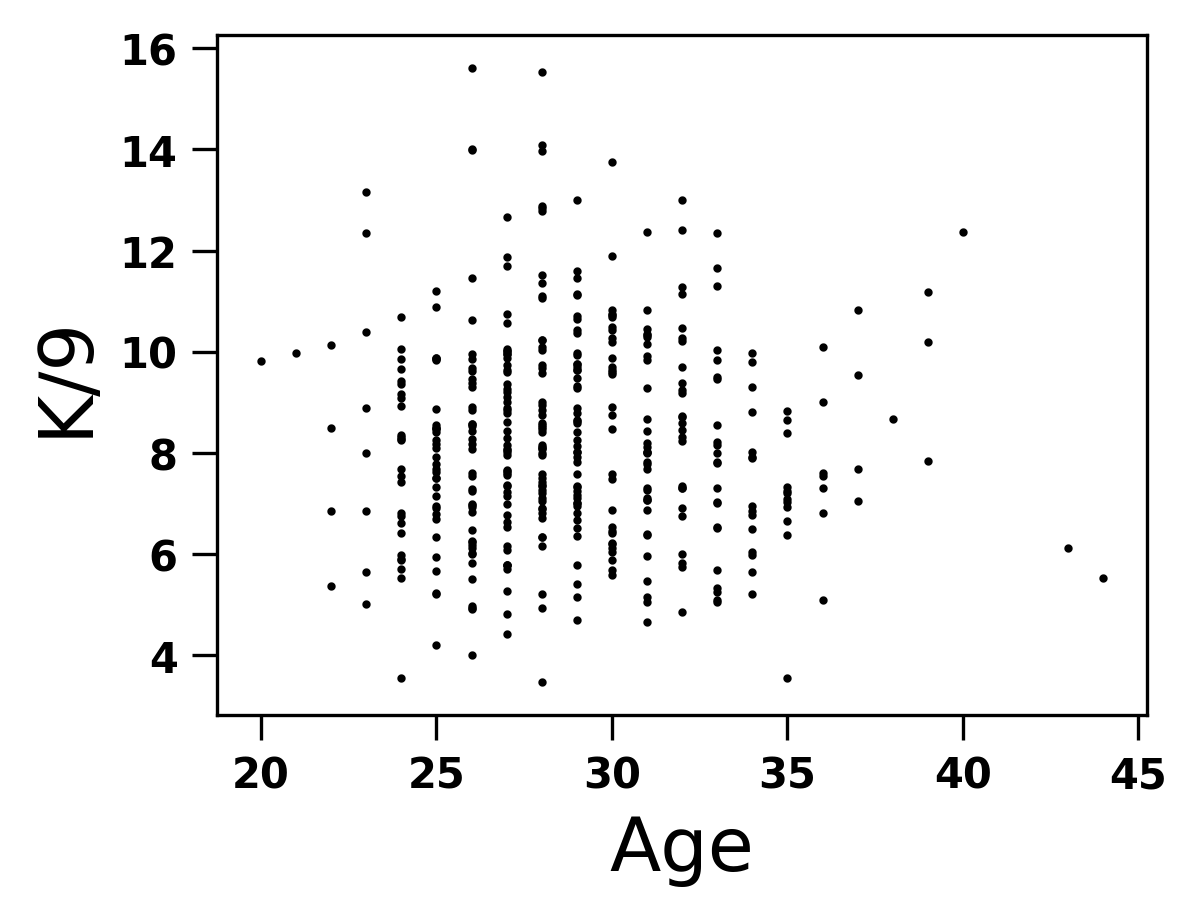

In [13]:
fig = plt.figure(figsize=(4,3))

for player in PVals.keys():
    try:
        plt.scatter(PVals[player]['age'][-1],PVals[player]['k9'][-1],color='black',s=1.)
    except:
        pass

plt.xlabel('Age',size=18)
plt.ylabel('K/9',size=18)

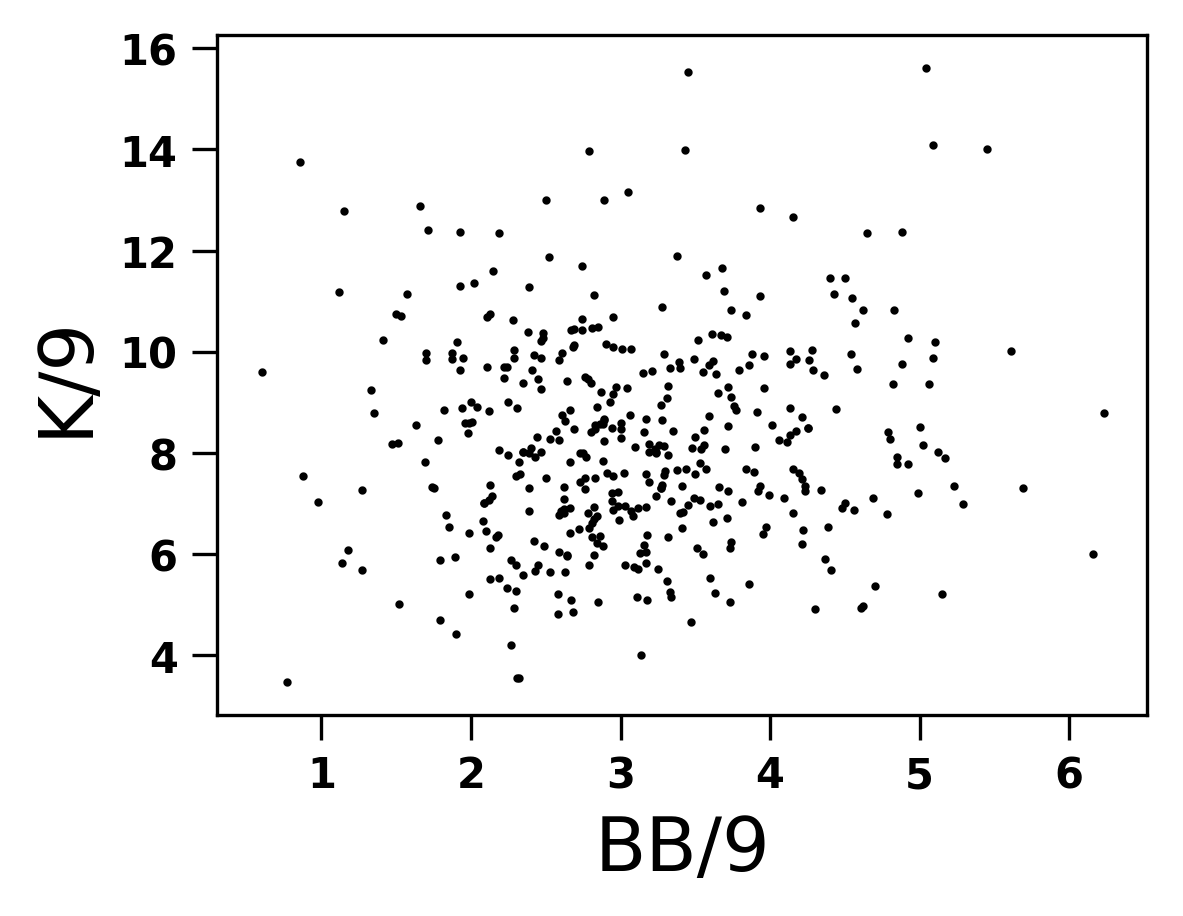

In [14]:
fig = plt.figure(figsize=(4,3))

for player in PVals.keys():
    try:
        plt.scatter(PVals[player]['bb9'][-1],PVals[player]['k9'][-1],color='black',s=1.)
    except:
        pass

plt.xlabel('BB/9',size=18)
plt.ylabel('K/9',size=18)

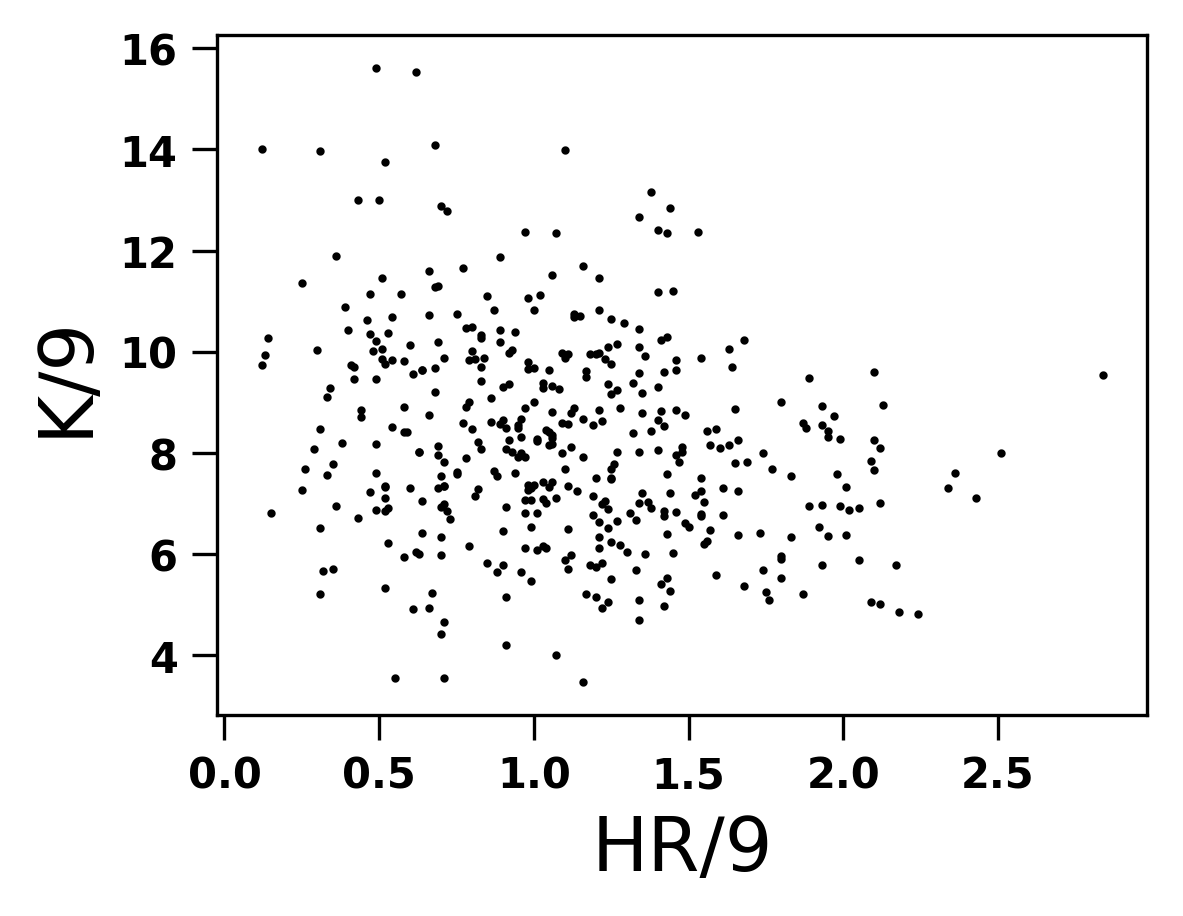

In [15]:
fig = plt.figure(figsize=(4,3))

for player in PVals.keys():
    try:
        plt.scatter(PVals[player]['hr9'][-1],PVals[player]['k9'][-1],color='black',s=1.)
    except:
        pass

plt.xlabel('HR/9',size=18)
plt.ylabel('K/9',size=18)

In [ ]:
for pval in PVals.keys(): print pval,PVals[pval]['age'],PVals[pval]['k9']


Demonstrate the different rows that are available for extracting year-on-year stats.

In [ ]:
#
# for an individual player
#

player = 'Brad Peacock'


get_url = 'http://www.fangraphs.com/statss.aspx?playerid='+str(PDict[player].strip())

get_url = 'http://www.fangraphs.com/statss.aspx?playerid=5401'



projections = ['Depth Charts','Fans (14)','Steamer',\
               'ZiPS', 'ZiPS (R)','Steamer (R)','Depth Charts (R)','Average']

minors = ['(AA)','(A)','(AAA)','(R)','(A+)','(A-)']

agg = ['Total']

r  = requests.get(get_url)

data = r.text

soup = BeautifulSoup(data)


tables = soup.findAll('table')

birth_year = float(get_birth_year(tables))

age = []
k9 = []

for indx,table in enumerate(tables):

    print indx,[th.get_text() for th in table.find("tr").find_all("th")]
   
    if indx==10:
        
        #print [th.get_text() for th in table.find("tr").find_all("th")]
        
        for row in table.find_all("tr")[1:]:
            sav = [td.get_text() for td in row.find_all("td")]
            #if (sav[0]=='2017') & (sav[1] not in projections) & (minors not in sav[1]): print sav
            if (sav[1] not in projections) & \
            (np.sum([(x in sav[1]) for x in minors])==0) & \
            (np.sum([(x in sav[0]) for x in agg])==0): 
                age.append(float(sav[0])-birth_year)
                k9.append(float(sav[2]))
            #print sav[1],np.sum([(x in sav[1]) for x in minors]),
    #        #print sav[0]
            


Now we have the ability to automatically grab the stat page for any player!

In [ ]:
    
#
# for an individual player
#

player = 'Brad Peacock'


get_url = 'http://www.fangraphs.com/statss.aspx?playerid='+str(PDict[player].strip())

get_url = 'http://www.fangraphs.com/statsd.aspx?playerid=5401&position=P'


projections = ['Depth Charts','Fans (14)','Steamer',\
               'ZiPS', 'ZiPS (R)','Steamer (R)','Depth Charts (R)','Average']

minors = ['(AA)','(A)','(AAA)','(R)','(A+)','(A-)']

agg = ['Total']

r  = requests.get(get_url)

data = r.text

soup = BeautifulSoup(data)


tables = soup.findAll('table')

birth_year = float(get_birth_year(tables))

age = []
k9 = []

for indx,table in enumerate(tables): print indx,[th.get_text() for th in table.find("tr").find_all("th")]
   
#    if indx==10:
#        
#        #print [th.get_text() for th in table.find("tr").find_all("th")]
#        
#        for row in table.find_all("tr")[1:]:
#            sav = [td.get_text() for td in row.find_all("td")]
#            #if (sav[0]=='2017') & (sav[1] not in projections) & (minors not in sav[1]): print sav
#            if (sav[1] not in projections) & \
#            (np.sum([(x in sav[1]) for x in minors])==0) & \
#            (np.sum([(x in sav[0]) for x in agg])==0): 
#                age.append(float(sav[0])-birth_year)
#                k9.append(float(sav[2]))
            #print sav[1],np.sum([(x in sav[1]) for x in minors]),
    #        #print sav[0]
            

